In [1]:
##
## VGG16 и VGG19 проверка результативности (реализации взяты с github keras/application):
##                  https://github.com/fchollet/keras/tree/master/keras/applications
##
## 2017-05-20
## maximum on LB => 0.84500
##
## TIF - (,,6) (,,3)
##
## 2017-07-06
##  TIF (64,64,6) - полная схема без выемки 09(cloudy) - то есть 17 признаков
##  
## 2017-07-09
##  TIF (64,64,6) - полная схема по признакам 4,5,6,7
##
## 2017-07-12
##  JPG+TIF (64x64x)==(128x128x) по результатам
##  BatchNarmalizstion не  поднимает результат
##  Наиболее быстрый и адекватный вариант классификационной части dense1024+dense1024
##  Ввод новых вегетационных признаков типа CCCI не приводит к улучшению. Либо также либо чуть хуже
##
## 2017-07-12
##  Проверяю полный прогон на VGG19 (для очистки совести и перехожу на другое)
##
## 2017-07-12
##  Проверил! LB=0.90004. Вставил VGG19 на наборе jpg128 + подставил насильственно веса от imagenet. Работает на train 9 часов.
##  Необходима специализированная препроцессорная обработка для imagenet (RGB-->BGR; минус спец среднее из изображений)
##
## 2017-07-15
##  Вернулся после неудач с другим сетями
##
## 2017-07-15
##
##  Попытка увеличить качество входного материала (resize+equalize) через fit-generator
##
##
##
##

In [2]:
import sys,os,datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import fbeta_score
import sklearn.metrics as skm

from __future__ import print_function

In [3]:
print(np.__version__);
print(pd.__version__);

1.12.1
0.19.2


In [4]:
import  cv2 as cv
cv.__version__

'3.2.0'

In [5]:
sys.path.append('../Python')
from helper import paths_input, formImExt, formImHist
from estimate import confusion_matrix, getConfusion, getRocAUC, getProb01, getProbX01, getTh, estimateResult

In [6]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Sequential,save_model,load_model, Model, Input
from keras.layers import Convolution2D, MaxPooling2D, Convolution1D, MaxPooling1D
from keras.layers import Activation, Dropout, Flatten, Dense, GlobalAveragePooling2D, GlobalMaxPooling2D
from keras.layers import Conv2D

from keras.applications.vgg19 import VGG19, preprocess_input

from keras.layers.normalization import BatchNormalization
import keras.optimizers
from keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint
import keras.backend as K

Using TensorFlow backend.


In [7]:
keras.__version__

'2.0.4'

In [8]:
trLabels,trDirTIF,trDirJPG,teDirTIF,teDirJPG = paths_input()
trDirI = trDirTIF
teDirI = teDirTIF
trWork, teWork = '../Work/Train', '../Work/Test'
trDirI,teDirI, teDirJPG, trWork, teWork

('../Data/train-tif-v2',
 '../Data/test-tif-v2',
 '../Data/test-jpg-v2',
 '../Work/Train',
 '../Work/Test')

In [9]:
labels_df = pd.read_csv(trLabels)
labels_df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [10]:
# Build list with unique labels
label_list = []
for tag_str in labels_df.tags.values:
    labels = tag_str.split(' ')
    for label in labels:
        if label not in label_list:
            label_list.append(label)

In [11]:
# Add onehot features for every label
for label in label_list:
    labels_df[label] = labels_df['tags'].apply(lambda x: 1 if label in x.split(' ') else 0)
    #labels_df[label].astype(np.int8)
# Display head
#labels_df.head()


In [12]:
weather_labels = ['clear', 'partly_cloudy', 'haze', 'cloudy']
land_labels = ['primary', 'agriculture', 'water', 'cultivation', 'habitation' ]
rare_labels = [l for l in label_list if labels_df[label_list].sum()[l] < 2000]
#rare_labels              

In [13]:
labels = label_list; #weather_labels;
nameList =labels_df[labels_df[labels].sum(axis=1)>0].image_name.tolist(); len(nameList)
labelList=labels_df[labels_df[labels].sum(axis=1)>0][labels].as_matrix();
labelList[:6,:]
#labels_df.head()

array([[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [14]:
len(labels_df.tags.unique())

449

In [15]:
#!rm ../Temp/Batch/*.npy

In [16]:
def generate_batches ( names_tags_df, dirIn, output_shape, classes=17, ext='.jpg', size=5000) :
    xx = np.zeros((size,output_shape[0],output_shape[1],output_shape[2]),dtype=np.float32);
    yy = np.zeros((size,classes),dtype=np.uint8);
    
    iijj = 0;
    
    for ii in range(0,len(names_tags_df),size) :
        yy    = labels_df[ii:min(ii+size,len(names_tags_df))].values[:,2:].astype(np.uint8);
        files = labels_df[ii:min(ii+size,len(names_tags_df))].image_name.tolist()
        files = [x+ext for x in files]
        for i in range(len(files)) :
            nf    = os.path.join(dirIn,files[i])
            xx[i] = formImExt(nf,EqualizeOK=True,resize=(output_shape[0],output_shape[1]))
            iijj += 1
            if (iijj%5000)==0 : print (datetime.datetime.now(),'-->',iijj)
        xx    = preprocess_input(xx)
        filexx= '../Temp/Batch/batch-{}-{}x{}x{}-XX.npy'.format(ii,output_shape[0],output_shape[1],output_shape[2])
        fileyy= '../Temp/Batch/batch-{}-{}x{}x{}-YY.npy'.format(ii,output_shape[0],output_shape[1],output_shape[2])
        np.save(filexx,xx)
        np.save(fileyy,yy)

In [17]:
# Препростройка для быстрой подачи batches
print(datetime.datetime.now())
##generate_batches(labels_df,trDirJPG,(224,224,3))
print(datetime.datetime.now())

2017-07-16 06:35:23.239517
2017-07-16 06:35:23.239710


In [106]:
def generate2_arrays_from_files (batch_size, n0=0, dirIn='../Temp/Batch', size=5000, output_shape=(224,224,3), classes=17, debugOK=False):
    
    while 1:
        
        ii = 0
        fi, bi = 0, 0
        #fi = (n0/size)*size
        if debugOK : print('read',fi,bi,bi+batch_size,fi+size)        
        fx = '../Temp/Batch/batch-{}-{}x{}x{}-XX.npy'
        fy = '../Temp/Batch/batch-{}-{}x{}x{}-YY.npy'
        xx = np.load(fx.format(fi,output_shape[0],output_shape[1],output_shape[2]));
        yy = np.load(fy.format(fi,output_shape[0],output_shape[1],output_shape[2]));
    
        while True :
            if (bi+batch_size)>size :
                if debugOK : print('read',fi,bi,bi+batch_size,fi+size)
                fi = fi + size
                fx = '../Temp/Batch/batch-{}-{}x{}x{}-XX.npy'
                fy = '../Temp/Batch/batch-{}-{}x{}x{}-YY.npy'
                xx = np.load(fx.format(fi,output_shape[0],output_shape[1],output_shape[2]));
                yy = np.load(fy.format(fi,output_shape[0],output_shape[1],output_shape[2]));
                if debugOK : print('xx,yy',xx.shape,yy.shape)
                bi = 0
            
            
            xxx, yyy, bi = xx[bi:bi+batch_size], yy[bi:bi+batch_size], bi+batch_size
            if debugOK : print('bi,xxx,yyy',fi,bi,xxx.shape,yyy.shape)
            
            yield (xxx, yyy)

def validate2_arrays_from_files (batch_size, n0=0, dirIn='../Temp/Batch', size=5000, output_shape=(224,224,3), classes=17, debugOK=False):
    
    
    
    while 1:
        
        ii = 0
        fi = (n0/size)*size
        bi =  n0-fi
        fx = '../Temp/Batch/batch-{}-{}x{}x{}-XX.npy'
        fy = '../Temp/Batch/batch-{}-{}x{}x{}-YY.npy'
        xx = np.load(fx.format(fi,output_shape[0],output_shape[1],output_shape[2]));
        yy = np.load(fy.format(fi,output_shape[0],output_shape[1],output_shape[2]));
    
        while True :
            if (bi+batch_size)>(fi+size) :
                fi = fi + size
                if debugOK : print('read',fi)
                xx = np.load(fx.format(fi,output_shape[0],output_shape[1],output_shape[2]));
                yy = np.load(fy.format(fi,output_shape[0],output_shape[1],output_shape[2]));
                bi = 0
            
            xxx, yyy, bi = xx[bi:bi+batch_size], yy[bi:bi+batch_size], bi+batch_size
            
            yield (xxx, yyy)

In [110]:
ba = 1000
zz = 0.1
xx = generate2_arrays_from_files(ba,debugOK=False);
x00= np.zeros((40497/ba*ba,3))
ii = 0;
for i in range(40497/ba) :
    xxx,yyy = xx.next();
    if (xxx.shape[0]==0) : print(i,xxx.shape)
    x0 = np.zeros((xxx.shape[0],xxx.shape[3]))
    for j in range(xxx.shape[0]) : 
        for k in range(3) :
            x0[j,k] = np.abs(xxx[j,:,:,k]).sum()
    x00[ii:ii+xxx.shape[0],:] = x0        
    ii += xxx.shape[0]

In [111]:
len(x00[x00[:,0]<0.1,0]), 40497/ba*ba, xxx.shape, yyy.shape

(0, 40000, (1000, 224, 224, 3), (1000, 17))

3319942.67869 115665.768778 0 16886


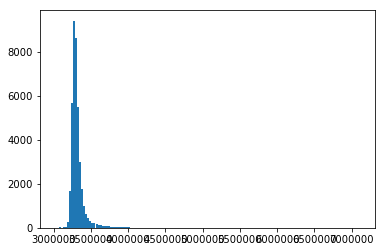

3204153.29661 122294.344893 0 24221


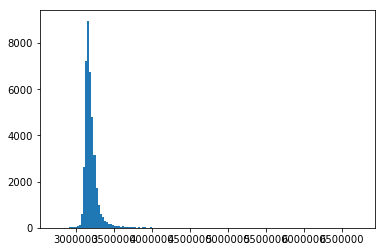

3130925.85895 87260.1552434 0 24221


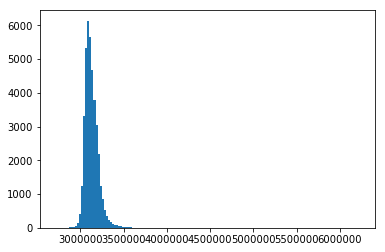

In [112]:
for i in range(3) :
    x000 = x00[:,i]
    print(x000.mean(), x000.std(), len(x000[x000<0.1]),x000.argmin())
    #plt.hist(x000[x000<0.0001].ravel(),bins=150); 
    plt.hist(x000.ravel(),bins=150); 
    plt.show(); plt.close()

In [19]:
def generate_arrays_from_files (batch_size, names_tags_df, dirIn, output_shape=(128,128,3), classes=17, ext='.jpg',debugOK=True):
    
    xx = np.zeros((batch_size,output_shape[0],output_shape[1],output_shape[2]),dtype=np.float32);
    yy = np.zeros((batch_size,classes),dtype=np.uint8);
    
    while 1:
        
        ii = 0
        for line1 in range(0,len(names_tags_df),batch_size) :
            filexx = os.path.join('../Temp/Batch/','tr-b{}-l1-{}-X.npy').format(batch_size,line1)
            fileyy = os.path.join('../Temp/Batch/','tr-b{}-l1-{}-Y.npy').format(batch_size,line1)
            if os.path.exists(filexx) :
                xx = np.load(filexx)
                yy = np.load(fileyy)
                ii +=1
                if debugOK and (ii%100==0) : print('generator: read:',xx.shape,yy.shape,ii,filexx)
            else :
                yy    = labels_df[line1:line1+batch_size].values[:,2:].astype(np.uint8);
                files = labels_df[line1:line1+batch_size].image_name.tolist()
                files = [x+ext for x in files]
                for i in range(len(files)) :
                    nf    = os.path.join(dirIn,files[i])
                    xx[i] = formImExt(nf,EqualizeOK=False,resize=(output_shape[0],output_shape[1]))
                xx    = preprocess_input(xx)
                np.save(filexx,xx)
                np.save(fileyy,yy)
                ii +=1
                if debugOK and (ii%100==0) : print('generator: save:',xx.shape,yy.shape,ii,filexx)
            #if debugOK : print('generator:',xx.shape,yy.shape)
            yield (xx, yy)
            #yield ({'input_1': xx}, {'output': yy})

def validate_arrays_from_files (batch_size, names_tags_df, dirIn, output_shape=(128,128,3), classes=17, ext='.jpg',debugOK=True):
    
    xx = np.zeros((batch_size,output_shape[0],output_shape[1],output_shape[2]),dtype=np.float32);
    yy = np.zeros((batch_size,classes),dtype=np.uint8);
    
    while 1:
        for line1 in range(0,len(names_tags_df),batch_size) :
            filexx = os.path.join('../Temp/Batch/','va-b{}-l1-{}-X.ba.npy').format(batch_size,line1)
            fileyy = os.path.join('../Temp/Batch/','va-b{}-l1-{}-Y.ba.npy').format(batch_size,line1)
            if os.path.exists(filexx) :
                xx = np.load(filexx)
                yy = np.load(fileyy)
            else :
                yy    = labels_df[line1:line1+batch_size].values[:,2:].astype(np.uint8);
                files = labels_df[line1:line1+batch_size].image_name.tolist()
                files = [x+ext for x in files]
                for i in range(len(files)) :
                    nf    = os.path.join(dirIn,files[i])
                    xx[i] = formImExt(nf,EqualizeOK=False,resize=(output_shape[0],output_shape[1]))
                xx    = preprocess_input(xx)
                np.save(filexx,xx)
                np.save(fileyy,yy)
            if debugOK : print('generator:',xx.shape,yy.shape)
            yield (xx, yy)

In [20]:
#labels_df[0:6].values[:,2:].astype(np.uint8)
xxyy = generate_arrays_from_files(5,labels_df,trDirJPG); xy=xxyy.next(); 
#xy[1]['output'].shape,  xy[0]['input_1'].shape, xy[1]['output']
#labels_df.head()

In [21]:
def fbeta_pred(y_true, y_pred, beta=2.0, OK1=0.2, eps=0.000001, printOK=False):
    beta2 = beta*beta
    yy_true = K.round(y_true)
    #yy_pred = K.round(y_pred+(0.5-OK1))
    yy_pred = K.round(y_pred)
    tp, tp_fp, fn = K.sum((yy_pred*yy_true)), K.sum(yy_true), K.sum((K.abs(yy_pred*(yy_true-1.0))))
    precision, recall = tp/(tp_fp+eps), tp/(tp+fn+eps) 
    fbeta = (1+beta2)*(precision*recall)/(beta2*precision+recall+eps)
    ##if fbeta>1.0 : fbeta = 1.0;
    if printOK :
        print('ten true ',K.get_value(yy_true))
        #print('ten pred ',y_pred)
        print('ten roun ',K.get_value(yy_pred))
        print(' pre=',K.get_value(precision),' recall=',K.get_value(recall),' tp=',
              K.get_value(tp),' fn=',K.get_value(fn),' tp+fp=',K.get_value(tp_fp))
    return(fbeta)

In [22]:
sizing = (224,224,3)
input_shape, output_classes, metric = sizing, 17, 'acc'
print(input_shape,output_classes)

(224, 224, 3) 17


In [23]:
model00 = VGG19(weights='imagenet', include_top=True)
for layer in model00.layers :
    if layer.name=='fc1' : fc1 = layer.get_weights()
    if layer.name=='fc2' : fc2 = layer.get_weights()
#model00.summary()
del model00

In [24]:
[x.shape for x in fc1], [x.shape for x in fc2]

([(25088, 4096), (4096,)], [(4096, 4096), (4096,)])

In [25]:
K.clear_session()
base_model = VGG19(weights='imagenet', include_top=False, pooling=None, input_shape=input_shape)

x = base_model.output

##print(base_model.summary())

##x = GlobalMaxPooling2D()(x) 
x = Flatten()(x)
initiaze = 'he_normal'
x = Dense(4096, activation='relu',kernel_initializer=initiaze, name='ffcc1')(x)
x = Dropout(0.25)(x)
x = Dense(4096, activation='relu',kernel_initializer=initiaze, name='ffcc2')(x)
x = Dropout(0.25)(x)


# and a logistic layer -- let's say we have 200 classes
predictions = Dense(output_classes, activation='softmax')(x)

# this is the model we will train
model10 = Model(inputs=base_model.input, outputs=predictions)


##for layer in base_model.layers : layer.Tranable = False

flag = ''
for layer in model10.layers :
    if layer.name=='ffcc1' : 
        ffcc = layer.get_weights(); flag+=' fc1'; print(flag,[x.shape for x in ffcc])
        if (ffcc[0].shape==fc1[0].shape) : ffcc[0]+=fc1[0]; flag+=' fc1-0'
        if (ffcc[1].shape==fc1[1].shape) : ffcc[1]+=fc1[1]; flag+=' fc1-1'
        layer.set_weights(ffcc)
    if layer.name=='ffcc2' :
        ffcc = layer.get_weights(); flag+=' fc2'
        if (ffcc[0].shape==fc2[0].shape) : ffcc[0]+=fc2[0]; flag+=' fc2-0'
        if (ffcc[1].shape==fc2[1].shape) : ffcc[1]+=fc2[1]; flag+=' fc2-1'
        layer.set_weights(ffcc)
        
print(flag)

sgd = keras.optimizers.SGD(nesterov=True)
model10.compile(loss='binary_crossentropy', # 'mean_absolute_error'
              optimizer=sgd, #"nadam", #sgd, #"adam", #'rmsprop',
              metrics=['acc']) #['binary_accuracy']) #[fbeta_pred]) #['accuracy',fbeta_pred]) #['accuracy'])

#model10.summary()

 fc1 [(25088, 4096), (4096,)]
 fc1 fc1-0 fc1-1 fc2 fc2-0 fc2-1


In [26]:
if False : 
    sweight  = np.zeros(trY.shape[0],dtype=np.float32);
    sweight[:]  = 1.0
    sweight[trY[:,0]==1] = 0.35
    sweight[trY[:,1]==1] = 0.25
    sweight[trY[:,2]==1] = 0.15
    sweight[trY[:,3]==1] = 0.05

In [ ]:
epochs     = 5
verbose    = 2
batch_size = 16
stopping   = 4

prefixTemp = 'vgg19G-jpg-tif-{}x{}x{}'.format(sizing[0],sizing[1],sizing[2])     

early_stopping = EarlyStopping(monitor='val_loss', patience=stopping,min_delta=0.0001)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=5, min_lr=0.001)

filepath="../Temp/Temp/"+prefixTemp+"-weights.{epoch:02d}-acc={"+metric+":.4f}-val_acc={val_"+metric+":.4f}-.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor=metric, verbose=1, save_best_only=True, mode='max')

step = 5000
low  = 5000
high = low+step

xxyy = 0
#trXX = trX #[trY[:,xxyy]==1]
#trYY = trY #[trY[:,xxyy]==1]

lb_df = labels_df
#lb_df = labels_df[low:high]
split = len(lb_df)-int(len(lb_df)/5.0)
generate, validate = lb_df[:split], lb_df[split:]

print(datetime.datetime.now())
#hist1  = model10.fit(trX[low:high],trY[low:high],
#hist1  = model10.fit(trX[low:high],trY[low:high],
hist1  = model10.fit_generator(generate2_arrays_from_files(batch_size,debugOK=False),
                    #generate_arrays_from_files(batch_size,generate,trDirJPG,ext='.jpg',output_shape=sizing,debugOK=True),
                    #sample_weight=sweight[low:high],
                    epochs=epochs, 
                    steps_per_epoch=int(len(generate)/batch_size),
                    validation_data=validate2_arrays_from_files(batch_size,n0=split,debugOK=False),
                    #validation_data=validate_arrays_from_files(batch_size,validate,trDirJPG,ext='.jpg',output_shape=sizing,debugOK=False),
                    validation_steps=int(len(validate)/batch_size),
                    callbacks=[early_stopping,checkpoint, reduce_lr],
                    verbose=verbose)

##trP = model1.predict(trX, batch_size=128)
##fbeta2score=fbeta_score(trY, np.array(trP) > 0.2, beta=2, average='samples')
##fbeta2pred =K.get_value(fbeta_pred(trY.astype(np.float64),trP.astype(np.float64)))
print(datetime.datetime.now()) #,pp,'fbeta2s=',fbeta2score,fbeta2pred)


2017-07-16 06:00:36.131300
Epoch 1/5


In [1]:
#fc1[1].shape, fc1[1][:10], fc2[0][:10], fc2[1][:10], ffcc[0][:10], ffcc[1][:10]

In [ ]:
sgd.get_config(); hist1.history
plt.plot(hist1.history['acc']); plt.plot(hist1.history['val_acc']); plt.show()
plt.plot(hist1.history['loss']); plt.plot(hist1.history['val_loss']); plt.show()
#hist1.history

In [ ]:
trX.shape, trY.shape

In [ ]:
%time trP = model10.predict(trX, batch_size=batch_size)
trP01       = getProb01(trP)
th, _       = getTh(trY,trP)
trP01x      = getProbX01(trP,th)

In [80]:
#print(model10.evaluate(trX,trY,verbose=2,batch_size=batch_size))
print(trY.shape)
print(trP.shape)
#print('fbeta_score=',fbeta_score(trY, np.array(trP) > 0.2, beta=2, average='samples'))
#print('fbeta_score=',fbeta_score(trY, np.array(trP) > 0.5, beta=2, average='samples'))
##-------------
print('fbeta_score=',fbeta_score(trY,trP01, beta=2, average='samples'))
print('fbeta_pred =',K.get_value(fbeta_pred(trY.astype(np.float64),trP01.astype(np.float64))))
##-------------
if trY.shape[1]==17 :
    print('fbeta_score=',fbeta_score(trY,trP01x, beta=2, average='samples'))
    print('fbeta_pred =',K.get_value(fbeta_pred(trY.astype(np.float64),trP01x.astype(np.float64))))

(40479, 17)
(40479, 17)
fbeta_score= 0.235712955756
fbeta_pred = 0.43852996984
fbeta_score= 0.936343915303
fbeta_pred = 0.93375767889


In [300]:
if False :
    freeze  = ('fc1','fc2','dropout_1','dropout_2','flatten')
    trainOK = ('input_1','predictions')
    for layer in model10.layers :
        #if (layer.name=='fc1') : layer.trainable = False
        #if (layer.name=='fc2') : layer.trainable = False
        if (layer.name in freeze) : layer.trainable = False
        else : layer.trainable = True
        if (layer.name in trainOK) : layer.trainable = True
        layer.trainable = True
        print(layer.name,layer.trainable)      

In [84]:
if True :
    save_model(model10,'../Data-Keras/Models/model-VGG19-128x128x3-d4096xd4096.h5')
    model10.save_weights('../Data-Keras/Models/model-VGG19-128x128x3-d4096xd4096-weights.h5')
    if False : # best 0x90004
        save_model(model10,'../Work/Join-XGB-NET/VGG19-LB=0x90004/model-VGG19-128x128x3-d4096xd4096.h5')
        model10.save_weights('../Work/Join-XGB-NET/VGG19-LB=0x90004/model-VGG19-128x128x3-d4096xd4096-weights.h5')
        np.save('../Work/Join-XGB-NET/VGG19-LB=0x90004/trIP01-XX.npy',trP01)
        np.save('../Work/Join-XGB-NET/VGG19-LB=0x90004/trIP-XX.npy', trP)
        np.save('../Work/Join-XGB-NET/VGG19-LB=0x90004/trIY-YY.npy',trY)

In [85]:
model10.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0         
__________

In [310]:
trP[0], trY[0], trP01[0], trP01x[0]

(array([  3.70237350e-01,   4.93190736e-01,   1.06996112e-03,
          1.33314744e-01,   6.74560608e-04,   9.84107974e-05,
          2.12351413e-04,   4.83186363e-04,   4.88138940e-05,
          1.42483710e-04,   7.10203385e-05,   1.37875631e-05,
          4.31219232e-05,   1.01183177e-05,   1.92909007e-04,
          5.11052203e-05,   1.45314596e-04], dtype=float32),
 array([1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.], dtype=float32),
 array([1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=uint8))

In [139]:
# Результативность

In [81]:
temp = estimateResult(trY,trP01x,printOK=True) # 40000 jpg128 (epoch=40,features=17) VGG19 d4096+d4096 +weights+imnet

0 acc=0.976679265792 roc=0.883524232955 not=944 yes=2093 no=37442 true=39535 all-1-0=(0.7760-0.9910)
1 acc=0.977642728328 roc=0.883610525919 not=905 yes=37280 no=2294 true=39574 all-1-0=(0.9938-0.7734)
2 acc=0.928926109835 roc=0.922535026704 not=2877 yes=11160 no=26442 true=37602 all-1-0=(0.9062-0.9389)
3 acc=0.973467724005 roc=0.967815856268 not=1074 yes=27913 no=11492 true=39405 all-1-0=(0.9818-0.9539)
4 acc=0.949825835618 roc=0.90710241146 not=2031 yes=6223 no=32225 true=38448 all-1-0=(0.8397-0.9745)
5 acc=0.961436794387 roc=0.849248928854 not=1561 yes=2607 no=36311 true=38918 all-1-0=(0.7123-0.9862)
6 acc=0.951258677339 roc=0.919828071166 not=1973 yes=7002 no=31504 true=38506 all-1-0=(0.8676-0.9721)
7 acc=0.932434101633 roc=0.767210724538 not=2735 yes=2485 no=35259 true=37744 all-1-0=(0.5551-0.9794)
8 acc=0.994960349811 roc=0.531001148943 not=204 yes=13 no=40262 true=40275 all-1-0=(0.0622-0.9998)
9 acc=0.99137824551 roc=0.963542756305 not=349 yes=1948 no=38182 true=40130 all-1-0=(0

In [312]:
temp = estimateResult(trY,trP01x,printOK=True) # 40000 jpg128 (epoch=40,features=17) VGG19 d4096+d4096 +weights+imnet LB=0.90004

0 acc=0.970824378073 roc=0.827535509167 not=1181 yes=1786 no=37512 true=39298 all-1-0=(0.6622-0.9929)
1 acc=0.976555744954 roc=0.877590365212 not=949 yes=37271 no=2259 true=39530 all-1-0=(0.9935-0.7616)
2 acc=0.917611601077 roc=0.909720294098 not=3335 yes=10955 no=26189 true=37144 all-1-0=(0.8896-0.9299)
3 acc=0.964376590331 roc=0.949960875432 not=1442 yes=28021 no=11016 true=39037 all-1-0=(0.9856-0.9143)
4 acc=0.937943131006 roc=0.87391779368 not=2512 yes=5728 no=32239 true=37967 all-1-0=(0.7729-0.9749)
5 acc=0.954074952444 roc=0.807677321803 not=1859 yes=2302 no=36318 true=38620 all-1-0=(0.6290-0.9864)
6 acc=0.942711035352 roc=0.901277662688 not=2319 yes=6718 no=31442 true=38160 all-1-0=(0.8324-0.9702)
7 acc=0.928012055634 roc=0.768147534975 not=2914 yes=2520 no=35045 true=37565 all-1-0=(0.5629-0.9734)
8 acc=0.994861533141 roc=0.507152201111 not=208 yes=3 no=40268 true=40271 all-1-0=(0.0144-1.0000)
9 acc=0.990464191309 roc=0.950839323708 not=386 yes=1894 no=38199 true=40093 all-1-0=(

In [50]:
#model.load_weights('../Data-Keras/train-model-2D-2-v2-loop-weights.h5') ## verify load weights from v1 version

In [86]:
# Forming output dataset for predicting --> trOX, trOY
del(trX)
del(trY)

In [87]:
trOX  = np.load('../Data-Keras/Datas/test-model-2D-128x128x3-jpg-XX.npy').astype(np.float32)
trOY  = np.load('../Data-Keras/Datas/test-model-2D-128x128x3-jpg-YY.npy')

In [88]:
# Препроцессорная обработка данных

trOX  = preprocess_input(trOX)

#trOX  = trOX[:, :, :, ::-1] # RGB --> BGR

##trX  = np.array(trX,dtype=np.float16)
#trOX[:, :, :, 0] -= 103.939
#trOX[:, :, :, 1] -= 116.779
#trOX[:, :, :, 2] -= 123.68
    


In [89]:
#
#  Построение решения для test массива на основе уровней прохождения (эффект почему-то дают)
#    Построенное решение 01 полное с учетом погодных критериев [0,3,9,10]
#        и особенности критерия cloudy (посмотреть и сменить можно в getProbX01)
#        Построение критериев прохождения в getTh
#

# test
trOP = model10.predict(trOX, batch_size=batch_size)

# Уровни прохождения & решение
trO01   = getProbX01(trOP,th)


In [90]:
#trO01[0:3],np.array(th),trOP[0:3]
if False :
    np.save('../Work/Join-XGB-NET/VGG19-LB=0x90004/trO01-OX.npy',trO01)
    np.save('../Work/Join-XGB-NET/VGG19-LB=0x90004/trOP-OX.npy', trOP)
    np.save('../Work/Join-XGB-NET/VGG19-LB=0x90004/trOY-OY.npy',trOY)

In [91]:
# Строим результат

In [92]:
trZ = trO01

In [93]:
temp_list = []
for i in range(trZ.shape[0]) :
    temp = [labels[ii] for ii in range(trZ.shape[1]) if trZ[i,ii]==1];
    temp = ' '.join(temp)
    temp_list.append([trOY[i],temp])
temp_list.sort(cmp=lambda x,y: cmp(int(x[0].partition('_')[2]),int(y[0].partition('_')[2])) if (x[0].partition('_')[0]==y[0].partition('_')[0]) else cmp(y[0].partition('_')[0],x[0].partition('_')[0]))


In [94]:
temp_list[0:5]

[['test_0', 'primary clear'],
 ['test_1', 'primary clear'],
 ['test_2', 'primary partly_cloudy'],
 ['test_3', 'primary agriculture clear'],
 ['test_4', 'cloudy']]

In [95]:
rrr=pd.DataFrame(temp_list,columns=['image_name','tags']); rrr.head(); 
suffixDT = (datetime.datetime.now()).strftime('%Y-%m-%d-%H-%M-%S'); print(suffixDT)
rrr.to_csv('../Result/vss'+suffixDT+'.csv',index=False);

2017-07-15-21-01-35


In [96]:
rrr.head()

,image_name,tags
0,test_0,primary clear
1,test_1,primary clear
2,test_2,primary partly_cloudy
3,test_3,primary agriculture clear
4,test_4,cloudy


In [ ]:
#-------------------------------------------------------------------------------------------------------------------------------

In [ ]:
# Склад барахла

In [ ]:
Skip to content
Features Business Explore Marketplace Pricing
This repository
Search
Sign in or Sign up
 Watch 1,176  Star 17,415  Fork 6,223 fchollet/keras
 Code  Issues 1,167  Pull requests 36  Projects 1  Wiki Insights 
Branch: master Find file Copy pathkeras/keras/applications/vgg19.py
bac1637  on 22 May
@taehoonlee taehoonlee Fix typos (#6702)
4 contributors @fchollet @taehoonlee @singlas @ozancaglayan
RawBlameHistory     
193 lines (167 sloc)  8.29 KB
# -*- coding: utf-8 -*-
"""VGG19 model for Keras.
# Reference
- [Very Deep Convolutional Networks for Large-Scale Image Recognition](https://arxiv.org/abs/1409.1556)
"""
from __future__ import print_function
from __future__ import absolute_import

import warnings

from ..models import Model
from ..layers import Flatten
from ..layers import Dense
from ..layers import Input
from ..layers import Conv2D
from ..layers import MaxPooling2D
from ..layers import GlobalAveragePooling2D
from ..layers import GlobalMaxPooling2D
from ..engine.topology import get_source_inputs
from ..utils import layer_utils
from ..utils.data_utils import get_file
from .. import backend as K
from .imagenet_utils import decode_predictions
from .imagenet_utils import preprocess_input
from .imagenet_utils import _obtain_input_shape


WEIGHTS_PATH = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg19_weights_tf_dim_ordering_tf_kernels.h5'
WEIGHTS_PATH_NO_TOP = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5'


def VGG19(include_top=True, weights='imagenet',
          input_tensor=None, input_shape=None,
          pooling=None,
          classes=1000):
    """Instantiates the VGG19 architecture.
    Optionally loads weights pre-trained
    on ImageNet. Note that when using TensorFlow,
    for best performance you should set
    `image_data_format="channels_last"` in your Keras config
    at ~/.keras/keras.json.
    The model and the weights are compatible with both
    TensorFlow and Theano. The data format
    convention used by the model is the one
    specified in your Keras config file.
    # Arguments
        include_top: whether to include the 3 fully-connected
            layers at the top of the network.
        weights: one of `None` (random initialization)
            or "imagenet" (pre-training on ImageNet).
        input_tensor: optional Keras tensor (i.e. output of `layers.Input()`)
            to use as image input for the model.
        input_shape: optional shape tuple, only to be specified
            if `include_top` is False (otherwise the input shape
            has to be `(224, 224, 3)` (with `channels_last` data format)
            or `(3, 224, 224)` (with `channels_first` data format).
            It should have exactly 3 inputs channels,
            and width and height should be no smaller than 48.
            E.g. `(200, 200, 3)` would be one valid value.
        pooling: Optional pooling mode for feature extraction
            when `include_top` is `False`.
            - `None` means that the output of the model will be
                the 4D tensor output of the
                last convolutional layer.
            - `avg` means that global average pooling
                will be applied to the output of the
                last convolutional layer, and thus
                the output of the model will be a 2D tensor.
            - `max` means that global max pooling will
                be applied.
        classes: optional number of classes to classify images
            into, only to be specified if `include_top` is True, and
            if no `weights` argument is specified.
    # Returns
        A Keras model instance.
    # Raises
        ValueError: in case of invalid argument for `weights`,
            or invalid input shape.
    """
    if weights not in {'imagenet', None}:
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization) or `imagenet` '
                         '(pre-training on ImageNet).')

    if weights == 'imagenet' and include_top and classes != 1000:
        raise ValueError('If using `weights` as imagenet with `include_top`'
                         ' as true, `classes` should be 1000')
    # Determine proper input shape
    input_shape = _obtain_input_shape(input_shape,
                                      default_size=224,
                                      min_size=48,
                                      data_format=K.image_data_format(),
                                      include_top=include_top)

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor
    # Block 1
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(img_input)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    # Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv4')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

    # Block 4
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv4')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

    # Block 5
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv4')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)

    if include_top:
        # Classification block
        x = Flatten(name='flatten')(x)
        x = Dense(4096, activation='relu', name='fc1')(x)
        x = Dense(4096, activation='relu', name='fc2')(x)
        x = Dense(classes, activation='softmax', name='predictions')(x)
    else:
        if pooling == 'avg':
            x = GlobalAveragePooling2D()(x)
        elif pooling == 'max':
            x = GlobalMaxPooling2D()(x)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = img_input
    # Create model.
    model = Model(inputs, x, name='vgg19')

    # load weights
    if weights == 'imagenet':
        if include_top:
            weights_path = get_file('vgg19_weights_tf_dim_ordering_tf_kernels.h5',
                                    WEIGHTS_PATH,
                                    cache_subdir='models')
        else:
            weights_path = get_file('vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5',
                                    WEIGHTS_PATH_NO_TOP,
                                    cache_subdir='models')
        model.load_weights(weights_path)
        if K.backend() == 'theano':
            layer_utils.convert_all_kernels_in_model(model)

        if K.image_data_format() == 'channels_first':
            if include_top:
                maxpool = model.get_layer(name='block5_pool')
                shape = maxpool.output_shape[1:]
                dense = model.get_layer(name='fc1')
                layer_utils.convert_dense_weights_data_format(dense, shape, 'channels_first')

            if K.backend() == 'tensorflow':
                warnings.warn('You are using the TensorFlow backend, yet you '
                              'are using the Theano '
                              'image data format convention '
                              '(`image_data_format="channels_first"`). '
                              'For best performance, set '
                              '`image_data_format="channels_last"` in '
                              'your Keras config '
                              'at ~/.keras/keras.json.')
    return model
Contact GitHub API Training Shop Blog About
© 2017 GitHub, Inc. Terms Privacy Security Status Help

In [ ]:
def VGG16 ( include_top=True, weights='imagenet',
          input_tensor=None, input_shape=None,
          pooling=None,
          classes=1000):
    """Instantiates the VGG16 architecture.
    Optionally loads weights pre-trained
    on ImageNet. Note that when using TensorFlow,
    for best performance you should set
    `image_data_format="channels_last"` in your Keras config
    at ~/.keras/keras.json.
    The model and the weights are compatible with both
    TensorFlow and Theano. The data format
    convention used by the model is the one
    specified in your Keras config file.
    # Arguments
        include_top: whether to include the 3 fully-connected
            layers at the top of the network.
        weights: one of `None` (random initialization)
            or "imagenet" (pre-training on ImageNet).
        input_tensor: optional Keras tensor (i.e. output of `layers.Input()`)
            to use as image input for the model.
        input_shape: optional shape tuple, only to be specified
            if `include_top` is False (otherwise the input shape
            has to be `(224, 224, 3)` (with `channels_last` data format)
            or `(3, 224, 224)` (with `channels_first` data format).
            It should have exactly 3 inputs channels,
            and width and height should be no smaller than 48.
            E.g. `(200, 200, 3)` would be one valid value.
        pooling: Optional pooling mode for feature extraction
            when `include_top` is `False`.
            - `None` means that the output of the model will be
                the 4D tensor output of the
                last convolutional layer.
            - `avg` means that global average pooling
                will be applied to the output of the
                last convolutional layer, and thus
                the output of the model will be a 2D tensor.
            - `max` means that global max pooling will
                be applied.
        classes: optional number of classes to classify images
            into, only to be specified if `include_top` is True, and
            if no `weights` argument is specified.
    # Returns
        A Keras model instance.
    # Raises
        ValueError: in case of invalid argument for `weights`,
            or invalid input shape.
    """
    if weights not in {'imagenet', None}:
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization) or `imagenet` '
                         '(pre-training on ImageNet).')

    if weights == 'imagenet' and include_top and classes != 1000:
        raise ValueError('If using `weights` as imagenet with `include_top`'
                         ' as true, `classes` should be 1000')
    # Determine proper input shape
    input_shape = _obtain_input_shape(input_shape,
                                      default_size=224,
                                      min_size=48,
                                      data_format=K.image_data_format(),
                                      include_top=include_top)

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor    
    # Block 1
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(img_input)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    # Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

    # Block 4
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

    # Block 5
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)

    if include_top:
        # Classification block
        x = Flatten(name='flatten')(x)
        x = Dense(4096, activation='relu', name='fc1')(x)
        x = Dense(4096, activation='relu', name='fc2')(x)
        x = Dense(classes, activation='softmax', name='predictions')(x)
    else:
        if pooling == 'avg':
            x = GlobalAveragePooling2D()(x)
        elif pooling == 'max':
            x = GlobalMaxPooling2D()(x)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = img_input
    # Create model.
    model = Model(inputs, x, name='vgg16')

    # load weights
    if weights == 'imagenet':
        if include_top:
            weights_path = get_file('vgg16_weights_tf_dim_ordering_tf_kernels.h5',
                                    WEIGHTS_PATH,
                                    cache_subdir='models')
        else:
            weights_path = get_file('vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5',
                                    WEIGHTS_PATH_NO_TOP,
                                    cache_subdir='models')
        model.load_weights(weights_path)
        if K.backend() == 'theano':
            layer_utils.convert_all_kernels_in_model(model)

        if K.image_data_format() == 'channels_first':
            if include_top:
                maxpool = model.get_layer(name='block5_pool')
                shape = maxpool.output_shape[1:]
                dense = model.get_layer(name='fc1')
                layer_utils.convert_dense_weights_data_format(dense, shape, 'channels_first')

            if K.backend() == 'tensorflow':
                warnings.warn('You are using the TensorFlow backend, yet you '
                              'are using the Theano '
                              'image data format convention '
                              '(`image_data_format="channels_first"`). '
                              'For best performance, set '
                              '`image_data_format="channels_last"` in '
                              'your Keras config '
                              'at ~/.keras/keras.json.')
    return model


In [209]:
if False :
    from keras.utils.data_utils import get_file
    WEIGHTS_PATH = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg19_weights_tf_dim_ordering_tf_kernels.h5'
    WEIGHTS_PATH_NO_TOP = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5'


    weights_path = get_file('vgg16_weights_tf_dim_ordering_tf_kernels.h5',
                                        WEIGHTS_PATH,
                                        cache_subdir='models')


In [ ]:
weights_path = get_file('vgg19_weights_tf_dim_ordering_tf_kernels.h5',
                        WEIGHTS_PATH,
                        cache_subdir='models')
weights_path = get_file('vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5',
                        WEIGHTS_PATH_NO_TOP,
                        cache_subdir='models')

In [27]:
def buildModel (iSize,rSize,params=None,cv2d=None,dense=None) :
    model = Sequential()
    if (cv2d is None) and (dense is None) and not (params is None) : cv2d, dense = params[:-2], params[-2:]
    model = Kriz2012x3x3(model,iSize,rSize,cv2d=cv2d,dense=dense,pp=params)
    sgd = keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.99, nesterov=True)
    model.compile(loss='mean_absolute_error',  #'binary_crossentropy',
                  optimizer="adam", #sgd, #"adam", #'rmsprop',
                  metrics=[fbeta_pred,'acc']) #['binary_accuracy']) #[fbeta_pred]) #['accuracy',fbeta_pred]) #['accuracy'])
    #sgd = keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    #model.compile(loss='categorical_crossentropy',
    #              optimizer='adam', #'adam', #sgd, #"adam", #'rmsprop',
    #              metrics=['accuracy']) #[fbeta_pred]) #['accuracy',fbeta_pred]) #['accuracy'])
    return(model)

def buildModelKriz (iSize,rSize) :
    model = Sequential()
    
    model = Kriz2012(model,iSize,rSize)
    #sgd = keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.99, nesterov=True)
    sgd = keras.optimizers.SGD(nesterov=True)
    model.compile(loss='binary_crossentropy', # 'mean_absolute_error'
                  optimizer="sgd", #sgd, #"adam", #'rmsprop',
                  metrics=['acc']) #['binary_accuracy']) #[fbeta_pred]) #['accuracy',fbeta_pred]) #['accuracy'])
    #sgd = keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    #model.compile(loss='categorical_crossentropy',
    #              optimizer='adam', #'adam', #sgd, #"adam", #'rmsprop',
    #              metrics=['accuracy']) #[fbeta_pred]) #['accuracy',fbeta_pred]) #['accuracy'])
    return(model)



In [93]:
K.clear_session()

In [83]:
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
#from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
import numpy as np

#model = VGG16(weights='imagenet', include_top=False)
model10 = VGG16(weights=None,input_shape=(224,224,3),include_top=True,classes=4)

#x = (Dense(512,activation='relu'))(model10)
#model10.add(Dropout(0.25))
#model10.add(Dense(4,activation='sigmoid'))

#img_path = 'elephant.jpg'
#img = image.load_img(img_path, target_size=(224, 224))
#x = image.img_to_array(img)
#x = np.expand_dims(x, axis=0)
#x = preprocess_input(x)

#features = model.predict(x)

In [114]:
#model10.summary()